In [147]:
# STEP 1: Import Libraries
# ------------------------
# Import all necessary libraries for data manipulation, visualization, and modeling.

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)

from xgboost import XGBRegressor, XGBClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(42)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

import shap
import seaborn as sns
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import networkx as nx
import lightgbm as lgb

# SMOTE to balance the binary target variable if there are fewer positive samples.
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# DATASET URL FROM GITHUB
dataset_url= "https://raw.githubusercontent.com/tabrezdn1/olympics-medal-prediction/refs/heads/main/olympics_dataset.csv"


# **EDA on DATASET**

In [148]:
df = pd.read_csv(dataset_url)

# Examine the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Display information about the dataset, including columns, dtypes, and missing values.
print("\nDataset Info:")
df.info()

First 5 rows of the dataset:
   player_id                   Name Sex            Team  NOC  Year  Season  \
0          0              A Dijiang   M           China  CHN  1992  Summer   
1          1               A Lamusi   M           China  CHN  2012  Summer   
2          2            Gunnar Aaby   M         Denmark  DEN  1920  Summer   
3          3            Edgar Aabye   M  Denmark/Sweden  DEN  1900  Summer   
4         26  Cornelia (-strannood)   F     Netherlands  NED  1932  Summer   

          City       Sport                         Event     Medal  
0    Barcelona  Basketball   Basketball Men's Basketball  No medal  
1       London        Judo  Judo Men's Extra-Lightweight  No medal  
2    Antwerpen    Football       Football Men's Football  No medal  
3        Paris  Tug-Of-War   Tug-Of-War Men's Tug-Of-War      Gold  
4  Los Angeles   Athletics  Athletics Women's 100 metres  No medal  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252565 entries, 0 to 25

In [149]:
missing_values = df.isnull().sum()
print(missing_values)

player_id    0
Name         0
Sex          0
Team         0
NOC          0
Year         0
Season       0
City         0
Sport        0
Event        0
Medal        0
dtype: int64


In [150]:
gender_counts = df['Sex'].value_counts().reset_index()
gender_counts.columns = ['Sex', 'Count']

fig = px.pie(gender_counts, names='Sex', values='Count',
             title='Gender Distribution of Athletes',
             color='Sex',
             color_discrete_map={'M':'blue', 'F':'pink', 'Unknown':'gray'})
fig.show()

In [151]:
top_countries = df['Team'].value_counts().head(10).reset_index()
top_countries.columns = ['Team', 'Athlete_Count']

fig = px.bar(top_countries, x='Athlete_Count', y='Team', orientation='h',
             title='Top 10 Countries by Athlete Count',
             labels={'Athlete_Count':'Number of Athletes', 'Team':'Country'},
             color='Athlete_Count',
             color_continuous_scale='Viridis')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [152]:
top10_countries = df['Team'].value_counts().nlargest(10).index
top10_df = df[df['Team'].isin(top10_countries)]
athletes_per_yr_cntry = top10_df.groupby(['Year', 'Team'])['player_id'].count().reset_index()
athletes_per_yr_cntry.columns = ['Year', 'Team','Athlete_Count']

fig = px.line(athletes_per_yr_cntry, x='Year', y='Athlete_Count', color='Team',
              labels={'Athlete_Count':'Number of Athletes'},title='Total Athletes per Year (Top 10 Countries)',
              color_discrete_sequence=["red","blue","yellow","green","pink","orange","purple","magenta","violet","cyan"])
fig.show()

In [153]:
# Group data by Year and ISO_Code to get Athlete_Count
athletes_per_country_year = df.groupby(['Year', 'NOC']).size().reset_index(name='Athlete_Count')

# Display the aggregated data
athletes_per_country_year.head()

,Year,NOC,Athlete_Count
0,1896,AUS,5
1,1896,AUT,8
2,1896,DEN,15
3,1896,FRA,26
4,1896,GBR,25


In [154]:
# Create the animated choropleth map
fig = px.choropleth(
    athletes_per_country_year,
    locations='NOC',
    color='Athlete_Count',
    hover_name='NOC',
    animation_frame='Year',
    color_continuous_scale='Blues',
    range_color=(athletes_per_country_year['Athlete_Count'].min(), athletes_per_country_year['Athlete_Count'].max()),
    title='Athletes Distribution by Country Over Time',
    labels={'Athlete_Count':'Number of Athletes'},
    projection='natural earth'
)

# Update geographical layout for better visualization
fig.update_geos(
    showcountries=True,
    showcoastlines=True,
    showland=True,
    fitbounds="locations",
    landcolor="lightgray",
    oceancolor="lightblue"
)

# Update layout for better aesthetics
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Number of Athletes",
        thickness=15,
        len=0.75,
        yanchor="top",
        y=0.95,
        ticks="outside"
    )
)

fig.show()

In [155]:
sunburst_data = df.groupby(['Sport', 'Event']).size().reset_index(name='Athlete_Count')

fig = px.sunburst(
    sunburst_data,
    path=['Sport', 'Event'],
    values='Athlete_Count',
    color='Athlete_Count',
    color_continuous_scale='RdBu',
    title='Hierarchy of Sports and Events by Athlete Count'
)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

In [156]:
# -----------------------------------
# 1. Load and Prepare the Dataset
# -----------------------------------

# Data Cleaning: Drop rows with missing critical information
df = df.dropna(subset=['Year', 'Sport', 'Sex', 'Team', 'NOC'])
df['Year'] = df['Year'].astype(int)

# Aggregate data: Count of athletes per Team (Country)
country_counts = df['Team'].value_counts().reset_index()
country_counts.columns = ['Team', 'Athlete_Count']

# Select top 10 countries for clarity in visualizations
top_n = 10
top_countries = country_counts.head(top_n)

# Extract unique NOC codes for the top countries
top_countries_noc = df[df['Team'].isin(top_countries['Team'])][['Team', 'NOC']].drop_duplicates()

# Merge NOC codes with top_countries
top_countries = top_countries.merge(top_countries_noc, on='Team', how='left')

# Verify unique NOC codes in top_countries
print("Unique NOC Codes in Top Countries:", top_countries['NOC'].unique())

# Aggregate data: Number of athletes per Sport and Year
surface_data = df.groupby(['Sport', 'Year']).size().reset_index(name='Athlete_Count')

# Create a pivot table with Sports as rows and Years as columns
surface_pivot = surface_data.pivot(index='Sport', columns='Year', values='Athlete_Count').fillna(0)

# Sort sports by total athlete count for better visualization
surface_pivot = surface_pivot.sort_values(by=surface_pivot.columns.tolist(), ascending=False)

# -----------------------------------
# 2. Initialize Subplots
# -----------------------------------

# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.6, 0.4],
    row_heights=[0.4, 0.6],
    specs=[
        [{"type": "scattergeo", "rowspan": 2}, {"type": "bar"}],
        [None, {"type": "surface"}]
    ],
    subplot_titles=(
        "Geographical Distribution of Athletes",
        "Top 10 Countries by Athlete Count",
        "Athlete Participation Across Sports and Years"
    ),
    horizontal_spacing=0.05,  # Reduced spacing between columns
    vertical_spacing=0.05     # Reduced spacing between rows
)

# -----------------------------------
# 3. Add Scattergeo Plot (Simulated 3D Globe)
# -----------------------------------

# Add Scattergeo map of athlete locations using NOC codes
scattergeo_trace = go.Scattergeo(
    locations=top_countries['NOC'],
    locationmode='ISO-3',  # Ensures that NOC codes are interpreted as ISO Alpha-3 codes
    text=top_countries['Team'] + ': ' + top_countries['Athlete_Count'].astype(str) + ' Athletes',
    mode="markers",
    marker=dict(
        color="crimson",
        size=top_countries['Athlete_Count'] / top_countries['Athlete_Count'].max() * 30,  # Scale marker sizes
        opacity=0.8
    ),
    hoverinfo="text"
)

fig.add_trace(
    scattergeo_trace,
    row=1, col=1
)

# -----------------------------------
# 4. Define Frames for Automatic Rotation
# -----------------------------------

# Define the number of frames and the step of rotation
num_frames = 72  # 72 frames for 360/5 degrees rotation steps
rotation_step = 5  # degrees per frame

frames = []

for i in range(num_frames):
    rotation = rotation_step * i
    frame = go.Frame(
        data=[
            go.Scattergeo(
                locations=top_countries['NOC'],
                locationmode='ISO-3',
                text=top_countries['Team'] + ': ' + top_countries['Athlete_Count'].astype(str) + ' Athletes',
                mode="markers",
                marker=dict(
                    color="crimson",
                    size=top_countries['Athlete_Count'] / top_countries['Athlete_Count'].max() * 30,
                    opacity=0.8
                ),
                hoverinfo="text"
            )
        ],
        layout=go.Layout(
            geo=dict(
                projection_rotation=dict(lon=rotation, lat=0, roll=0)
            )
        )
    )
    frames.append(frame)

# Add frames to the figure
fig.frames = frames

# -----------------------------------
# 5. Update Geos for Initial Layout
# -----------------------------------

# Update the Scattergeo projection to 'orthographic' for a globe-like appearance
fig.update_geos(
    projection_type="orthographic",
    showcountries=True,
    showcoastlines=True,
    showland=True,
    landcolor="lightgray",
    oceancolor="Darkblue",
    countrycolor="white",
    showocean=True,
    resolution=50,
    projection_rotation=dict(lon=0, lat=0, roll=0)  # Initial rotation
)

# -----------------------------------
# 6. Add Animation Controls
# -----------------------------------

# Add updatemenus for Play and Pause buttons
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(label="Play",
                     method="animate",
                     args=[
                         None,
                         dict(frame=dict(duration=50, redraw=True),
                              transition=dict(duration=0),
                              fromcurrent=True,
                              mode='immediate')
                     ]),
                dict(label="Pause",
                     method="animate",
                     args=[
                         [None],
                         dict(frame=dict(duration=0, redraw=False),
                              transition=dict(duration=0),
                              mode='immediate')
                     ])
            ],
            direction="left",
            pad={"r": 10, "t": 87},
            showactive=False,
            x=0.1,
            xanchor="right",
            y=0,
            yanchor="top"
        )
    ]
)

# -----------------------------------
# 7. Add Bar Chart
# -----------------------------------

# Add bar chart of top 10 countries
fig.add_trace(
    go.Bar(
        x=top_countries['Athlete_Count'][::-1],  # Reverse for descending order
        y=top_countries['Team'][::-1],
        orientation='h',
        marker=dict(color="crimson"),
        hoverinfo='x',
        showlegend=False
    ),
    row=1, col=2
)

# Rotate x-axis labels for the bar chart for better readability
fig.update_xaxes(tickangle=0, row=1, col=2)
# fig.update_yaxes(title_text="Countries", row=1, col=2)

# -----------------------------------
# 8. Add 3D Surface Plot
# -----------------------------------

# Add 3D surface of athlete participation
fig.add_trace(
    go.Surface(
        z=surface_pivot.values,
        x=surface_pivot.columns.astype(int).tolist(),
        y=surface_pivot.index.tolist(),
        colorscale='Cividis',
        showscale=True,
        colorbar=dict(title='Number of Athletes'),
        opacity=0.8
    ),
    row=2, col=2
)

# -----------------------------------
# 9. Final Layout Adjustments
# -----------------------------------

# Update layout settings
fig.update_layout(
    template="plotly_dark",
    margin=dict(r=20, t=150, b=60, l=80),
    height=900,  # Increased height for better visibility
    width=1200,  # Increased width for better visibility
    title_text="Olympic Athletes Dashboard: Geographical Distribution, Top Countries, and Participation Trends",
    annotations=[
        dict(
            text="Source: Olympics Dataset",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=0
        )
    ],
    hovermode='closest',
    title_font_size=24,
    title_x=0.5  # Center the title
)

# -----------------------------------
# 10. Display the Figure
# -----------------------------------

fig.show()


Unique NOC Codes in Top Countries: ['USA' 'GBR' 'FRA' 'ITA' 'GER' 'AUS' 'CAN' 'JPN' 'HUN' 'SWE']


In [157]:
df_medals = df[df['Medal'].notnull()]

# Aggregate medal counts by Year and NOC
medal_counts = df_medals.groupby(['Year', 'NOC']).size().reset_index(name='Medal_Count')

# Create animated bar chart
fig = px.bar(medal_counts,
             x='NOC',
             y='Medal_Count',
             color='NOC',
             animation_frame='Year',
             range_y=[0, medal_counts['Medal_Count'].max() + 50],
             title='Medal Counts by Country Over Years',
             labels={'NOC':'Country', 'Medal_Count':'Number of Medals'},
             color_discrete_sequence=["red","blue","yellow","green","pink","orange","purple","magenta","violet","cyan"])

fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [158]:
# Aggregate medal types
medal_tally = df_medals.groupby(['NOC', 'Medal']).size().reset_index(name='Count')

# Create bubble chart
fig = px.scatter(medal_tally,
                 x='NOC',
                 y='Count',
                 size='Count',
                 color='Medal',
                 hover_name='NOC',
                 title='Medal Tally by Country and Medal Type',
                 labels={'NOC': 'Country', 'Count': 'Number of Medals'},
                 size_max=60,
                color_discrete_sequence=["orange","blue","silver","gold"])



# **Binary Classification**

Lets start by implementing a binary classification to check if the country will win gold or no

The goal was to predict whether a country (identified by its NOC code) wins at least one gold medal in a given Olympic year. This is a binary classification task where:

1 (Yes): The country wins at least one gold medal. 0 (No): The country does not win any gold medals.

In [159]:
df = pd.read_csv(dataset_url)

# Examine the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Display information about the dataset, including columns, dtypes, and missing values.
print("\nDataset Info:")
df.info()

First 5 rows of the dataset:
   player_id                   Name Sex            Team  NOC  Year  Season  \
0          0              A Dijiang   M           China  CHN  1992  Summer   
1          1               A Lamusi   M           China  CHN  2012  Summer   
2          2            Gunnar Aaby   M         Denmark  DEN  1920  Summer   
3          3            Edgar Aabye   M  Denmark/Sweden  DEN  1900  Summer   
4         26  Cornelia (-strannood)   F     Netherlands  NED  1932  Summer   

          City       Sport                         Event     Medal  
0    Barcelona  Basketball   Basketball Men's Basketball  No medal  
1       London        Judo  Judo Men's Extra-Lightweight  No medal  
2    Antwerpen    Football       Football Men's Football  No medal  
3        Paris  Tug-Of-War   Tug-Of-War Men's Tug-Of-War      Gold  
4  Los Angeles   Athletics  Athletics Women's 100 metres  No medal  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252565 entries, 0 to 25

In [160]:
# Keep relevant columns and make a deep copy
data = df[['Year', 'NOC', 'Medal']].copy()

# Handle missing values
data.dropna(subset=['NOC', 'Medal'], inplace=True)

# Create a binary target: "Wins Gold" or "Does Not Win Gold"
data['gold_winner'] = data['Medal'].apply(lambda x: 1 if x == 'Gold' else 0)

data.head()

,Year,NOC,Medal,gold_winner
0,1992,CHN,No medal,0
1,2012,CHN,No medal,0
2,1920,DEN,No medal,0
3,1900,DEN,Gold,1
4,1932,NED,No medal,0


In [161]:
# Aggregate data by NOC and Year
noc_gold = data.groupby(['NOC', 'Year'])['gold_winner'].sum().reset_index()
noc_gold['gold_winner'] = noc_gold['gold_winner'].apply(lambda x: 1 if x > 0 else 0)

data.head()

,Year,NOC,Medal,gold_winner
0,1992,CHN,No medal,0
1,2012,CHN,No medal,0
2,1920,DEN,No medal,0
3,1900,DEN,Gold,1
4,1932,NED,No medal,0


In [162]:
# Add participation feature: Count of unique events participated in by each NOC per year
participation = data.groupby(['NOC', 'Year'])['Medal'].count().reset_index(name='total_participations')
noc_gold = noc_gold.merge(participation, on=['NOC', 'Year'], how='left')

print(noc_gold.head())

   NOC  Year  gold_winner  total_participations
0  AFG  1936            0                    16
1  AFG  1948            0                    25
2  AFG  1956            0                    12
3  AFG  1960            0                    16
4  AFG  1964            0                     8


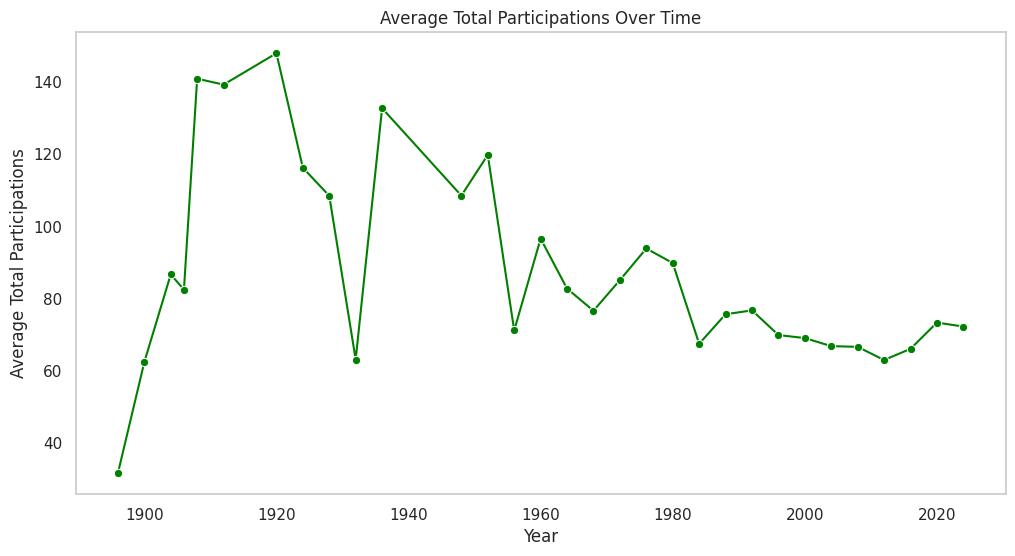

In [163]:
# Group by Year and calculate mean total_participations
yearly_participation = noc_gold.groupby('Year')['total_participations'].mean().reset_index()

# Plot the trend
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='total_participations', data=yearly_participation, marker='o', color="green")
plt.title("Average Total Participations Over Time")
plt.xlabel("Year")
plt.ylabel("Average Total Participations")
plt.grid()
plt.show()

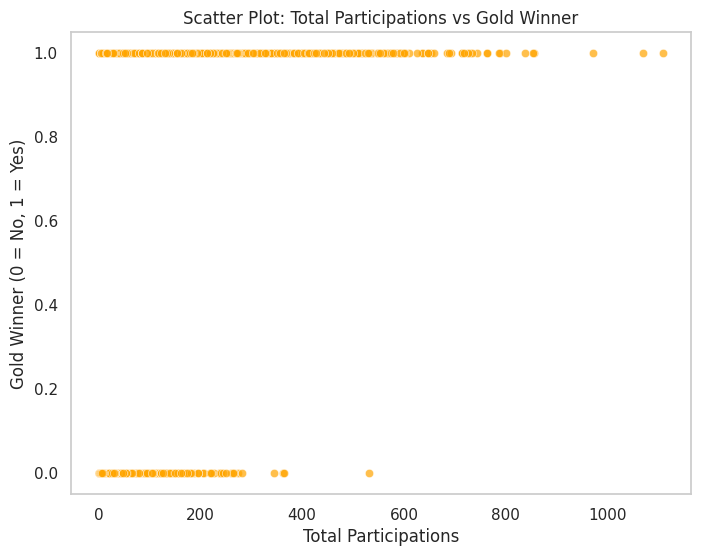

In [164]:
# Scatter plot for total_participations and gold_winner
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_participations', y='gold_winner', data=noc_gold, alpha=0.7, color="orange")
plt.title("Scatter Plot: Total Participations vs Gold Winner")
plt.xlabel("Total Participations")
plt.ylabel("Gold Winner (0 = No, 1 = Yes)")
plt.grid()
plt.show()

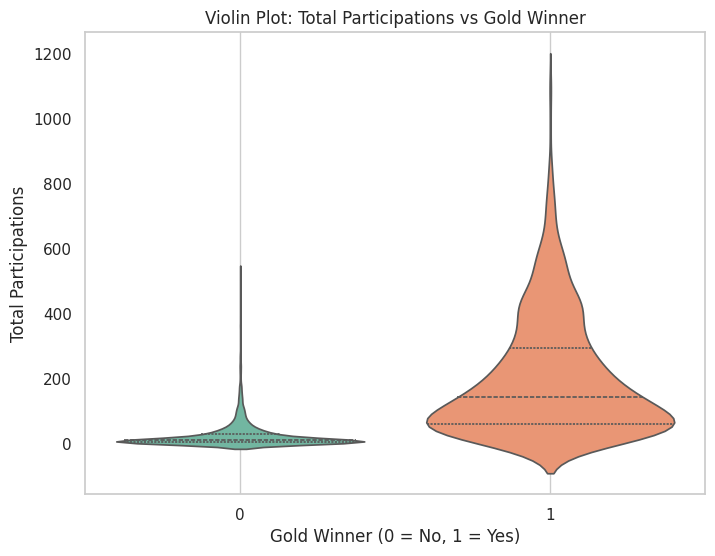

In [165]:
# Violin Plot: Distribution of total_participations for gold_winner categories
plt.figure(figsize=(8, 6))
sns.violinplot(x='gold_winner', y='total_participations', data=noc_gold, palette="Set2", inner="quartile", hue='gold_winner', dodge=False, legend=False)
plt.title("Violin Plot: Total Participations vs Gold Winner")
plt.xlabel("Gold Winner (0 = No, 1 = Yes)")
plt.ylabel("Total Participations")
plt.grid()
plt.show()

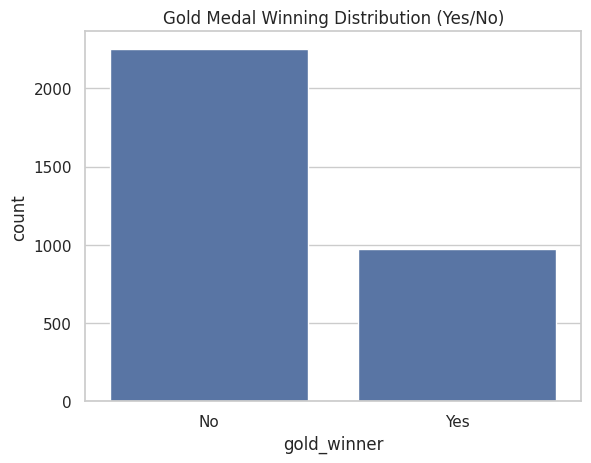

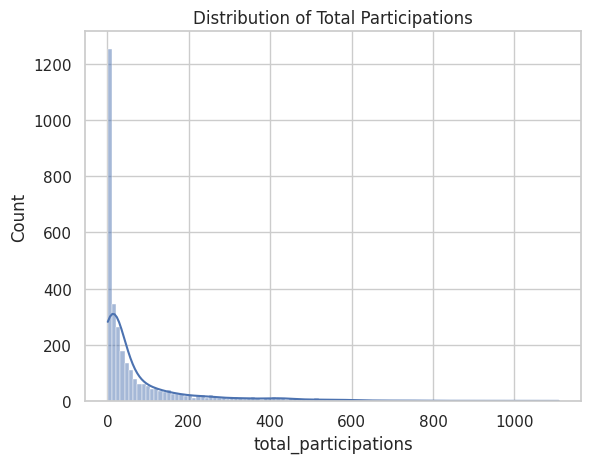

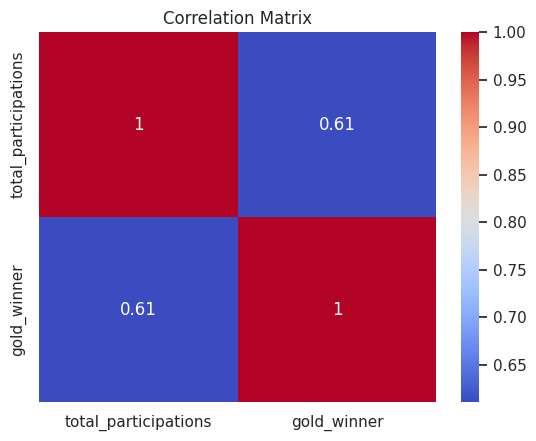

In [166]:
# Target variable distribution
sns.countplot(data=noc_gold, x='gold_winner')
plt.title("Gold Medal Winning Distribution (Yes/No)")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# Distribution of participation counts
sns.histplot(noc_gold['total_participations'], kde=True)
plt.title("Distribution of Total Participations")
plt.show()

# Correlation matrix
corr_matrix = noc_gold[['total_participations', 'gold_winner']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

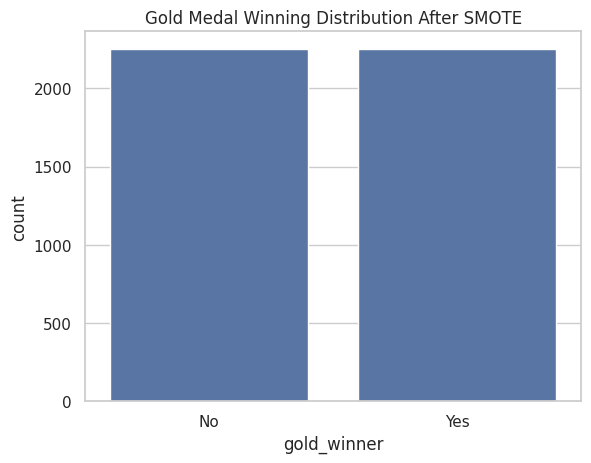

In [167]:
# Features and target
X = noc_gold[['total_participations']]
y = noc_gold['gold_winner']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check distribution after SMOTE
sns.countplot(x=y_resampled)
plt.title("Gold Medal Winning Distribution After SMOTE")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       463
           1       0.83      0.85      0.84       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901



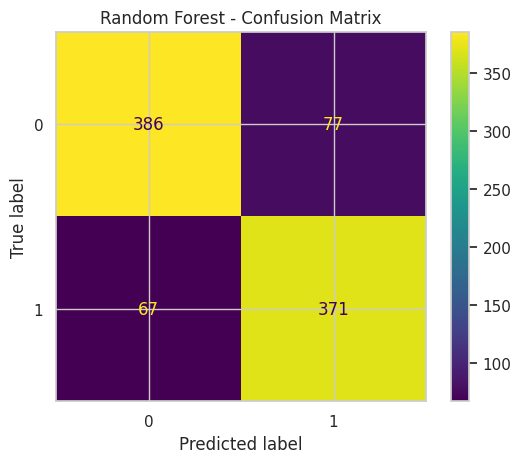

Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       463
           1       0.89      0.78      0.83       438

    accuracy                           0.84       901
   macro avg       0.85      0.84      0.84       901
weighted avg       0.85      0.84      0.84       901



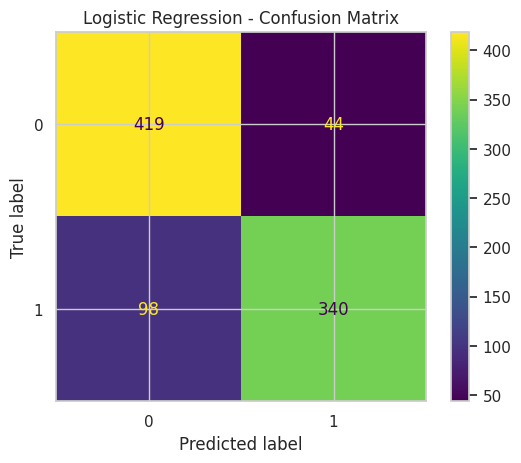

Training SVM...

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       463
           1       0.84      0.85      0.85       438

    accuracy                           0.85       901
   macro avg       0.85      0.85      0.85       901
weighted avg       0.85      0.85      0.85       901



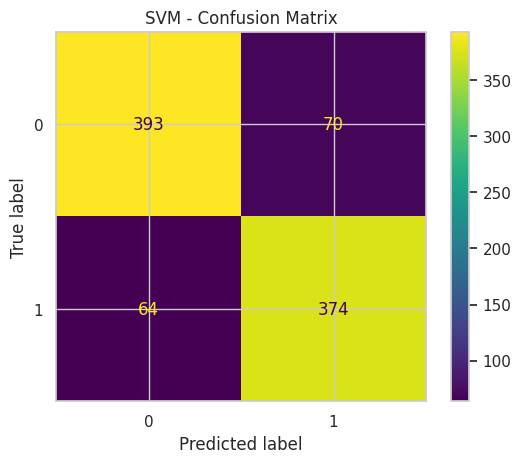

Training KNN...

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       463
           1       0.76      0.84      0.79       438

    accuracy                           0.79       901
   macro avg       0.79      0.79      0.79       901
weighted avg       0.79      0.79      0.79       901



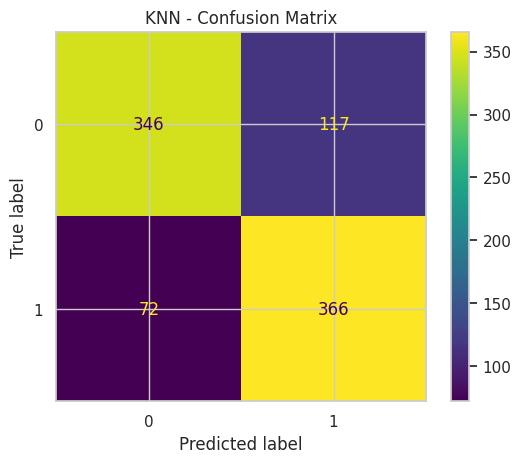

Training Decision Tree...

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       463
           1       0.83      0.83      0.83       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901



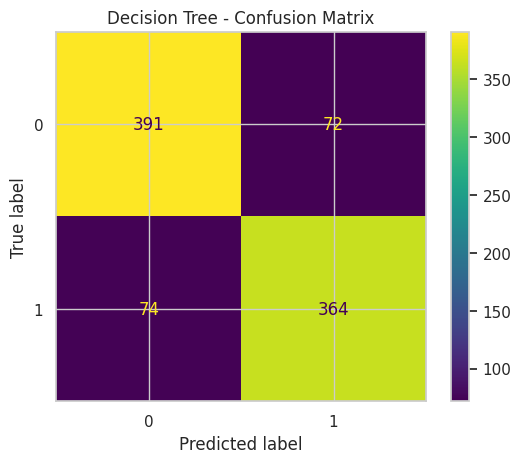

Training AdaBoost...

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       463
           1       0.79      0.89      0.84       438

    accuracy                           0.83       901
   macro avg       0.84      0.84      0.83       901
weighted avg       0.84      0.83      0.83       901



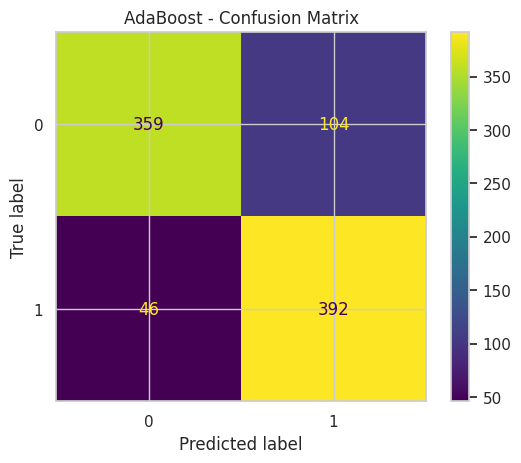

Training XGBoost...

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       463
           1       0.81      0.87      0.84       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901



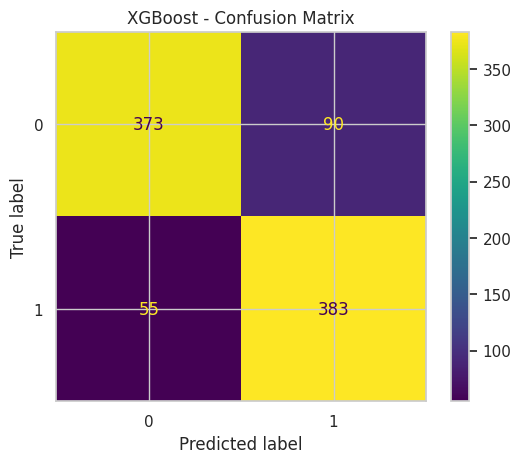

Training LightGBM...
[LightGBM] [Info] Number of positive: 1814, number of negative: 1789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503469 -> initscore=0.013878
[LightGBM] [Info] Start training from score 0.013878

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       463
           1       0.81      0.86      0.83       438

    accuracy                           0.83       901
   macro avg       0.83      0.83      0.83       901
weighted avg       0.83      0.83      0.83       901



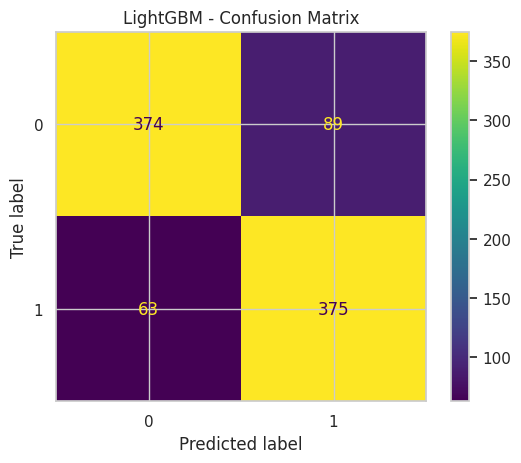


Model Comparison Summary:
                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Random Forest        0.840178   0.828125  0.847032  0.837472  0.917392
Logistic Regression  0.842397   0.885417  0.776256  0.827251  0.929650
SVM                  0.851276   0.842342  0.853881  0.848073  0.910715
KNN                  0.790233   0.757764  0.835616  0.794788  0.881806
Decision Tree        0.837958   0.834862  0.831050  0.832952  0.908437
AdaBoost             0.833518   0.790323  0.894977  0.839400  0.926028
XGBoost              0.839068   0.809725  0.874429  0.840834  0.930062
LightGBM             0.831299   0.808190  0.856164  0.831486  0.925752


In [168]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.ensemble")


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale features for models requiring scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

# Initialize results dictionary
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")

    # Train and predict
    if name in ["SVM", "KNN", "Logistic Regression"]:  # Scaled data required
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:  # Unscaled data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Store metrics in results dictionary
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc
    }

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Display confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# Convert results to DataFrame for summary
results_df = pd.DataFrame(results).T

# Print model comparison summary
print("\nModel Comparison Summary:")
print(results_df)


<Figure size 1400x800 with 0 Axes>

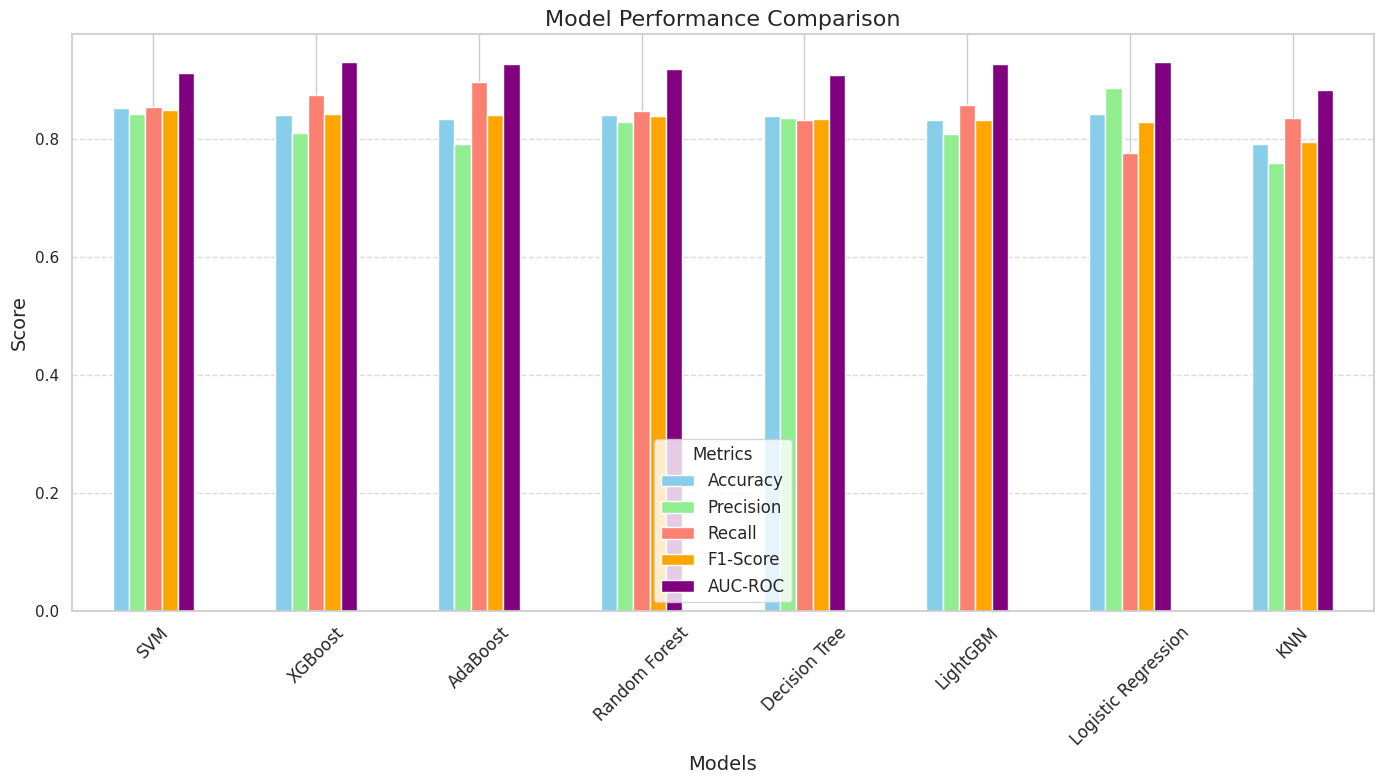

In [169]:
# Plot a bar chart for model comparison
def plot_model_comparison(results_df):
    # Sort by F1-Score for better visualization
    sorted_results = results_df.sort_values(by="F1-Score", ascending=False)

    # Plot the comparison
    plt.figure(figsize=(14, 8))
    sorted_results[["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]].plot(
        kind="bar", figsize=(14, 8), color=["skyblue", "lightgreen", "salmon", "orange", "purple"]
    )
    plt.title("Model Performance Comparison", fontsize=16)
    plt.ylabel("Score", fontsize=14)
    plt.xlabel("Models", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title="Metrics", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_model_comparison(results_df)

In [170]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.002, 0.005],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='f1',
    verbose=0  # Reduce verbosity
)

# Fit GridSearchCV
print("Starting Grid Search...")
grid_xgb.fit(X_train, y_train)

# Print intermediate results
cv_results = pd.DataFrame(grid_xgb.cv_results_)
print("\nIntermediate Results:")
print(cv_results[['mean_test_score', 'params']])

# Get the best parameters and model
print("\nBest parameters for XGBoost:", grid_xgb.best_params_)
best_xgb = grid_xgb.best_estimator_


Starting Grid Search...

Intermediate Results:
     mean_test_score                                             params
0           0.839844  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
1           0.838528  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
2           0.836003  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
3           0.838528  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
4           0.837143  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
..               ...                                                ...
103         0.838090  {'colsample_bytree': 1.0, 'learning_rate': 0.0...
104         0.839791  {'colsample_bytree': 1.0, 'learning_rate': 0.0...
105         0.839959  {'colsample_bytree': 1.0, 'learning_rate': 0.0...
106         0.838528  {'colsample_bytree': 1.0, 'learning_rate': 0.0...
107         0.839960  {'colsample_bytree': 1.0, 'learning_rate': 0.0...

[108 rows x 2 columns]

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning

In [171]:
#Tuning SVM with GridSearchCV
# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],             # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'], # Kernel types
    'gamma': ['scale', 'auto']           # Kernel coefficient
}

# Initialize GridSearchCV for SVM
grid_svm = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid_svm,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
print("Starting Grid Search for SVM...")
grid_svm.fit(X_train_scaled, y_train)  # Use scaled data for SVM

# Print intermediate results
cv_results_svm = pd.DataFrame(grid_svm.cv_results_)
print("\nIntermediate Results for SVM:")
print(cv_results_svm[['mean_test_score', 'params']])

# Get the best parameters and model
print("\nBest parameters for SVM:", grid_svm.best_params_)
best_svm = grid_svm.best_estimator_

Starting Grid Search for SVM...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Intermediate Results for SVM:
    mean_test_score                                            params
0          0.797206  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
1          0.813834     {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
2          0.830333    {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
3          0.797206   {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
4          0.814282      {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
5          0.831954     {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
6          0.802244    {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
7          0.829160       {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
8          0.839546      {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
9          0.802244     {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
10         0.829160        {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
11         0.839546       {'C': 1, '

In [172]:
# XGBoost Classification Report
print("XGBoost Classification Report:")
y_xgb_pred = best_xgb.predict(X_test)
print(classification_report(y_test, y_xgb_pred))

# SVM Classification Report
print("SVM Classification Report:")
y_svm_pred = best_svm.predict(X_test_scaled)  # Scaled data for SVM
print(classification_report(y_test, y_svm_pred))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       463
           1       0.79      0.88      0.84       438

    accuracy                           0.83       901
   macro avg       0.84      0.83      0.83       901
weighted avg       0.84      0.83      0.83       901

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       463
           1       0.78      0.90      0.84       438

    accuracy                           0.83       901
   macro avg       0.84      0.83      0.83       901
weighted avg       0.84      0.83      0.83       901



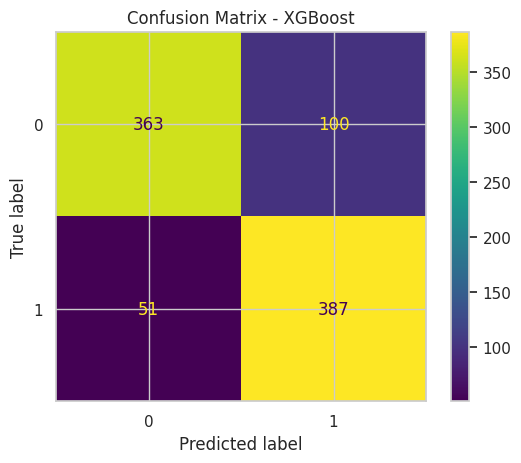

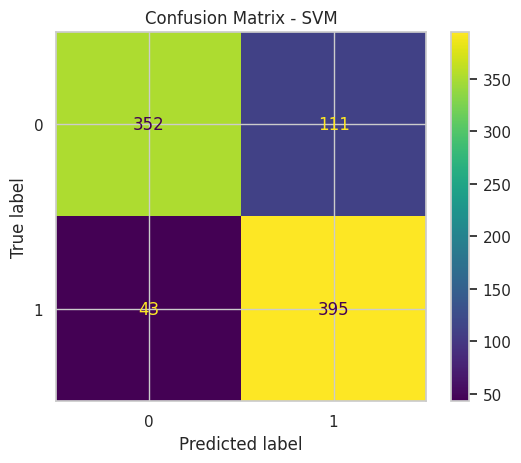

In [173]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plots a confusion matrix for the given true and predicted values.
    """
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# XGBoost Confusion Matrix
y_xgb_pred = best_xgb.predict(X_test)
plot_confusion_matrix(y_test, y_xgb_pred, "XGBoost")

# SVM Confusion Matrix
y_svm_pred = best_svm.predict(X_test_scaled)  # Scaled data for SVM
plot_confusion_matrix(y_test, y_svm_pred, "SVM")


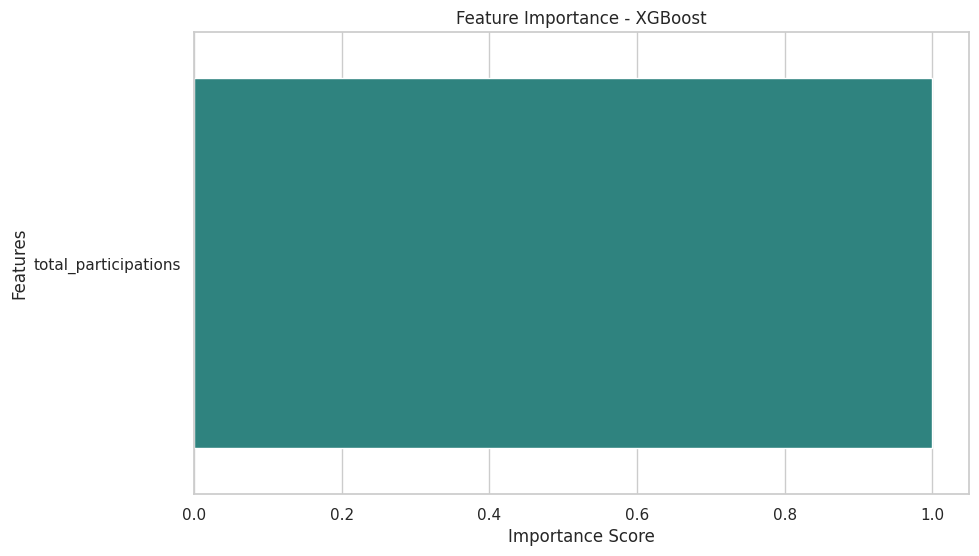

In [174]:
plt.figure(figsize=(10, 6))
sns.barplot(x=best_xgb.feature_importances_, y=X.columns, palette="viridis", hue=X.columns, dodge=False, legend=False)
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


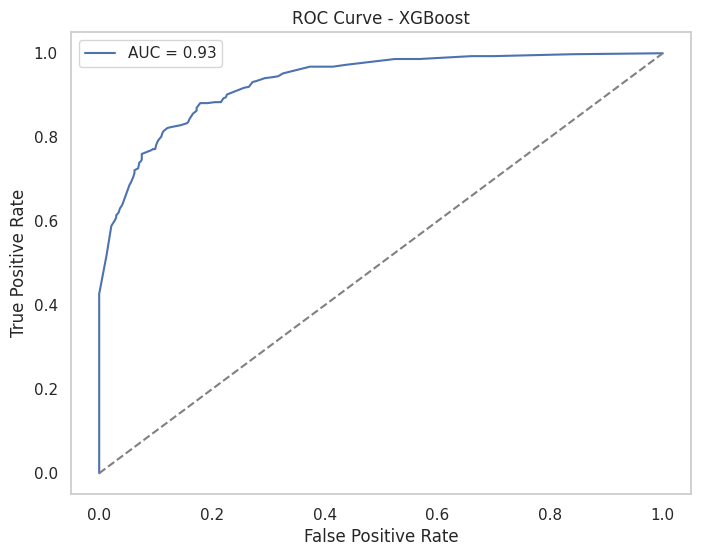

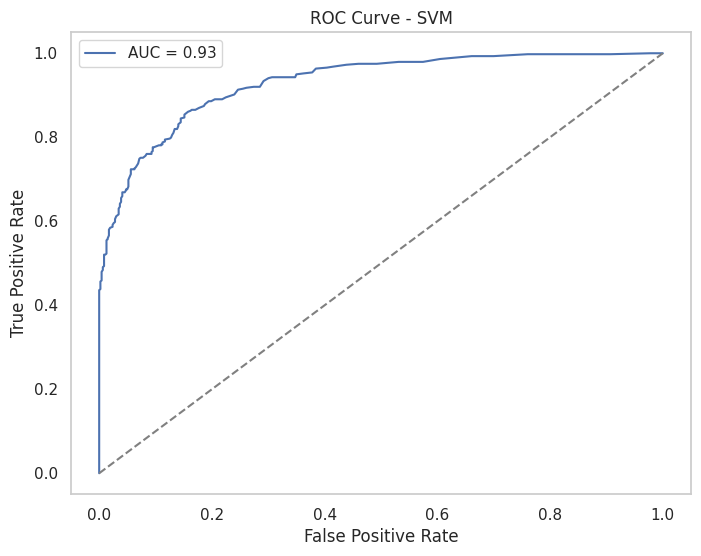

In [175]:
# Define the function to plot ROC Curve for any model
def plot_roc_curve(y_true, y_proba, model_name):
    """
    Plots the ROC curve and calculates the AUC for a given model.
    """
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

# XGBoost AUC-ROC Curve
y_xgb_proba = best_xgb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_xgb_proba, "XGBoost")

# SVM AUC-ROC Curve
y_svm_proba = best_svm.predict_proba(X_test_scaled)[:, 1]
plot_roc_curve(y_test, y_svm_proba, "SVM")

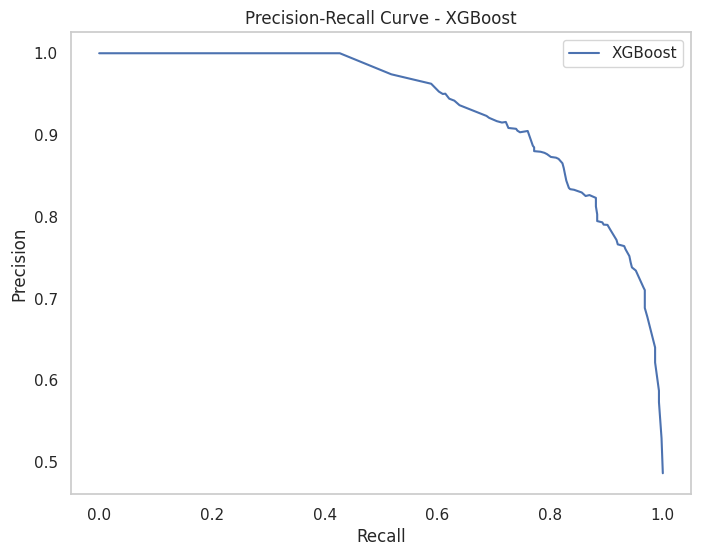

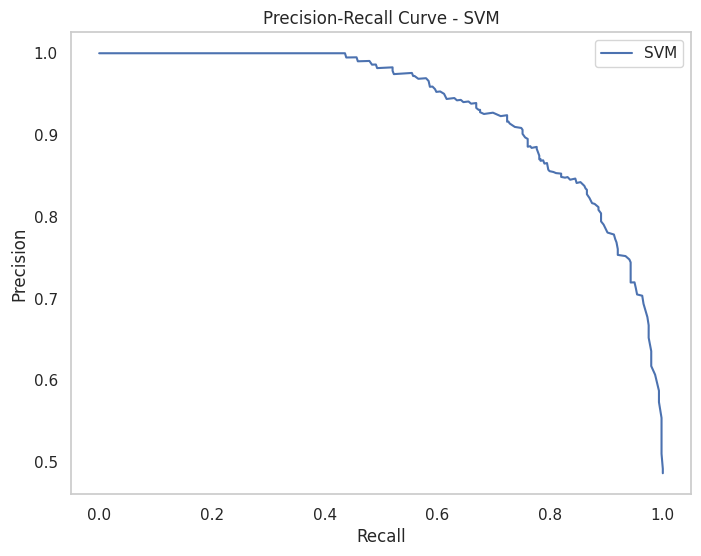

In [176]:
# Define the function to plot Precision-Recall Curve for any model
def plot_precision_recall_curve(y_true, y_proba, model_name):
    """
    Plots the Precision-Recall curve for a given model.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"{model_name}")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.legend()
    plt.show()

# XGBoost Precision-Recall Curve
y_xgb_proba = best_xgb.predict_proba(X_test)[:, 1]  # Ensure best_xgb is available
plot_precision_recall_curve(y_test, y_xgb_proba, "XGBoost")

# SVM Precision-Recall Curve
y_svm_proba = best_svm.predict_proba(X_test_scaled)[:, 1]  # Ensure best_svm is available
plot_precision_recall_curve(y_test, y_svm_proba, "SVM")


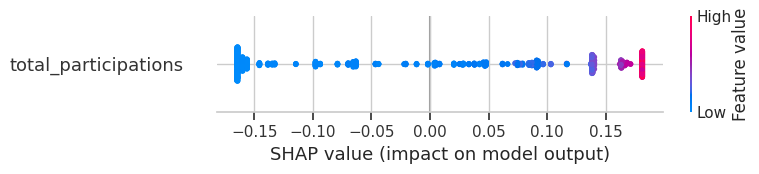

In [177]:
# XGBoost SHAP
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns)

  0%|          | 0/901 [00:00<?, ?it/s]

SHAP values shape: (1, 2)
Feature matrix shape: (901, 1)


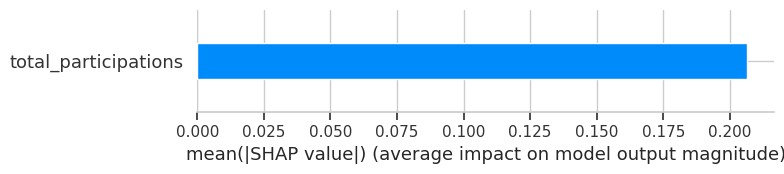

In [178]:

# Initialize SHAP KernelExplainer
explainer_svm = shap.KernelExplainer(best_svm.predict_proba, shap.sample(X_test_scaled, 100))

# Compute SHAP values
shap_values_svm = explainer_svm.shap_values(X_test_scaled)

# Check SHAP values and feature matrix dimensions
print("SHAP values shape:", shap_values_svm[1].shape)
print("Feature matrix shape:", X_test_scaled.shape)

# Extract SHAP values for the positive class
shap_values_svm_adjusted = shap_values_svm[1][:, 0]

# Plot SHAP summary as a bar plot (single feature)
shap.summary_plot(
    shap_values_svm_adjusted.reshape(-1, 1),
    X_test_scaled,
    plot_type="bar",
    feature_names=["total_participations"]
)


# **Regression Model**

In [179]:
# Step 1: Load the Data
# ---------------------------------------------------------------
df = pd.read_csv(dataset_url)

# Step 2: Initial Data Exploration
# ---------------------------------------------------------------
print("Data Shape:", df.shape)
print(df.head())
df.info()

# Step 3: Data Cleaning
# ---------------------------------------------------------------
df['Medal'] = df['Medal'].fillna('No Medal')


Data Shape: (252565, 11)
   player_id                   Name Sex            Team  NOC  Year  Season  \
0          0              A Dijiang   M           China  CHN  1992  Summer   
1          1               A Lamusi   M           China  CHN  2012  Summer   
2          2            Gunnar Aaby   M         Denmark  DEN  1920  Summer   
3          3            Edgar Aabye   M  Denmark/Sweden  DEN  1900  Summer   
4         26  Cornelia (-strannood)   F     Netherlands  NED  1932  Summer   

          City       Sport                         Event     Medal  
0    Barcelona  Basketball   Basketball Men's Basketball  No medal  
1       London        Judo  Judo Men's Extra-Lightweight  No medal  
2    Antwerpen    Football       Football Men's Football  No medal  
3        Paris  Tug-Of-War   Tug-Of-War Men's Tug-Of-War      Gold  
4  Los Angeles   Athletics  Athletics Women's 100 metres  No medal  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252565 entries, 0 to 252564
Data columns (

In [180]:
# Step 3: Feature Engineering for Medal Counts
# ---------------------------------------------------------------
df['Medal_Count'] = df['Medal'].apply(lambda x: 0 if x == 'No Medal' else 1)

# Aggregate total medals by (NOC, Year)
country_year = df.groupby(['NOC', 'Year'], as_index=False)['Medal_Count'].sum()
country_year.rename(columns={'Medal_Count': 'Total_Medals'}, inplace=True)

# Number of athletes
athletes_per_country_year = df.groupby(['NOC', 'Year'])['Name'].nunique().reset_index()
athletes_per_country_year.rename(columns={'Name': 'Num_Athletes'}, inplace=True)

# Number of sports
sports_per_country_year = df.groupby(['NOC', 'Year'])['Sport'].nunique().reset_index()
sports_per_country_year.rename(columns={'Sport': 'Num_Sports'}, inplace=True)

# Merge features
country_year = country_year.merge(athletes_per_country_year, on=['NOC', 'Year'], how='left')
country_year = country_year.merge(sports_per_country_year, on=['NOC', 'Year'], how='left')

# Season flag
season_per_country_year = df.groupby(['NOC','Year'])['Season'].first().reset_index()
country_year = country_year.merge(season_per_country_year, on=['NOC','Year'], how='left')
country_year['Season_Flag'] = country_year['Season'].apply(lambda x: 1 if x == 'Summer' else 0)
country_year.drop(columns='Season', inplace=True)

# Reset index after merges
country_year.reset_index(drop=True, inplace=True)

# Step 5: Historical Performance Feature
# ---------------------------------------------------------------
country_year = country_year.sort_values(by=['NOC','Year']).reset_index(drop=True)
country_year['Avg_Past_Medals'] = (country_year.groupby('NOC')['Total_Medals']
                                   .apply(lambda x: x.shift().expanding().mean())
                                   .reset_index(level=0, drop=True))
country_year['Avg_Past_Medals'] = country_year['Avg_Past_Medals'].fillna(0)

print("Data after adding historical feature:")
print(country_year.head(10))

Data after adding historical feature:
   NOC  Year  Total_Medals  Num_Athletes  Num_Sports  Season_Flag  \
0  AFG  1936            16            15           2            1   
1  AFG  1948            25            22           2            1   
2  AFG  1956            12            12           1            1   
3  AFG  1960            16            12           2            1   
4  AFG  1964             8             8           1            1   
5  AFG  1968             5             5           1            1   
6  AFG  1972             8             8           1            1   
7  AFG  1980            11            11           2            1   
8  AFG  1988             5             5           1            1   
9  AFG  1996             2             2           1            1   

   Avg_Past_Medals  
0         0.000000  
1        16.000000  
2        20.500000  
3        17.666667  
4        17.250000  
5        15.400000  
6        13.666667  
7        12.857143  
8        12.6


Base Model Results:
                          MSE       MAE        R²
Linear Regression  275.745515  8.928938  0.982263
Random Forest      232.524404  7.837499  0.985044
Gradient Boosting  203.867028  7.494575  0.986887
XGBoost            282.690209  8.560976  0.981817

Tuning Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}

Tuning Gradient Boosting...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Gradient Boosting Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}

Tuned Random Forest - MSE: 227.0597, MAE: 7.7124, R²: 0.9854
Tuned Gradient Boosting - MSE: 252.0520, MAE: 9.2137, R²: 0.9838


<Figure size 1000x600 with 0 Axes>

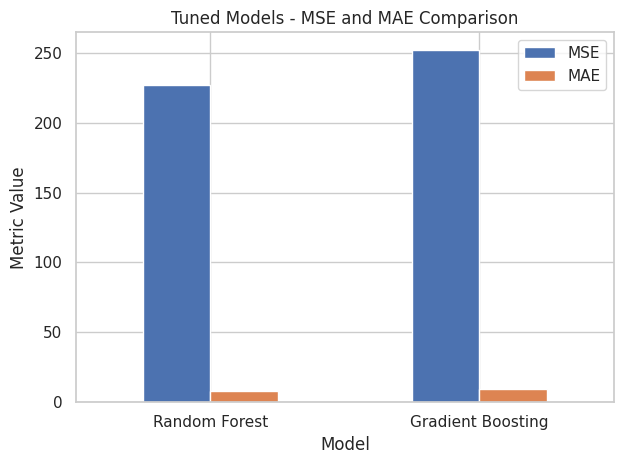

<Figure size 1000x600 with 0 Axes>

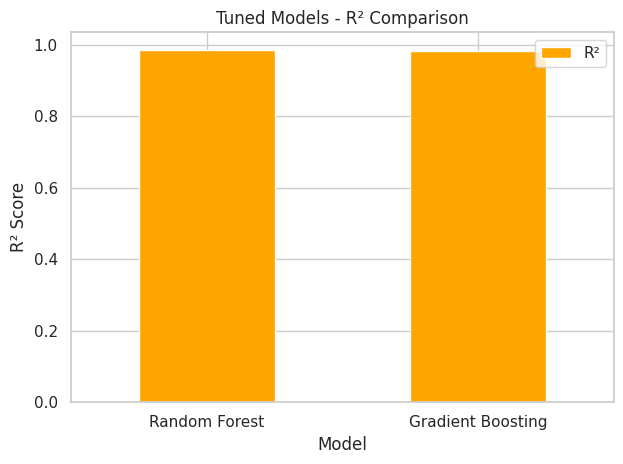


Best model selected after tuning: Random Forest with R² = 0.9854


In [181]:
# Step 6: Prepare Data for Modeling
# ---------------------------------------------------------------
features = ['Num_Athletes', 'Num_Sports', 'Season_Flag', 'Avg_Past_Medals']
X = country_year[features]
y = country_year['Total_Medals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Base Model Training and Evaluation
# ---------------------------------------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror')
}

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

base_results = {}
for name, m in models.items():
    m.fit(X_train, y_train)
    mse, mae, r2 = evaluate_model(m, X_test, y_test)
    base_results[name] = {'MSE': mse, 'MAE': mae, 'R²': r2}

base_results_df = pd.DataFrame(base_results).T
print("\nBase Model Results:")
print(base_results_df)

# Step 8: Hyperparameter Tuning for Top Two Models (e.g. Random Forest and Gradient Boosting)
# ---------------------------------------------------------------
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.001],
    'max_depth': [3, 5, 7]
}

print("\nTuning Random Forest...")
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                       rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
print("Best Random Forest Params:", rf_grid.best_params_)

print("\nTuning Gradient Boosting...")
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42),
                       gb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting Params:", gb_grid.best_params_)

best_rf = rf_grid.best_estimator_
best_gb = gb_grid.best_estimator_

rf_mse, rf_mae, rf_r2 = evaluate_model(best_rf, X_test, y_test)
gb_mse, gb_mae, gb_r2 = evaluate_model(best_gb, X_test, y_test)

print("\nTuned Random Forest - MSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}".format(rf_mse, rf_mae, rf_r2))
print("Tuned Gradient Boosting - MSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}".format(gb_mse, gb_mae, gb_r2))

# Compare tuned models visually (Separate MSE/MAE and R² plots)
tuned_results = pd.DataFrame({
    'MSE': [rf_mse, gb_mse],
    'MAE': [rf_mae, gb_mae],
    'R²': [rf_r2, gb_r2]
}, index=['Random Forest', 'Gradient Boosting'])

# Plot MSE and MAE in one graph
plt.figure(figsize=(10,6))
tuned_results[['MSE','MAE']].plot(kind='bar', rot=0)
plt.title("Tuned Models - MSE and MAE Comparison")
plt.xlabel("Model")
plt.ylabel("Metric Value")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Plot R² in another graph
plt.figure(figsize=(10,6))
tuned_results[['R²']].plot(kind='bar', rot=0, color='orange')
plt.title("Tuned Models - R² Comparison")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Step 9: Select Best Model
# ---------------------------------------------------------------
if gb_r2 >= rf_r2:
    final_model = best_gb
    best_model_name = "Gradient Boosting"
else:
    final_model = best_rf
    best_model_name = "Random Forest"

print(f"\nBest model selected after tuning: {best_model_name} with R² = {max(gb_r2, rf_r2):.4f}")

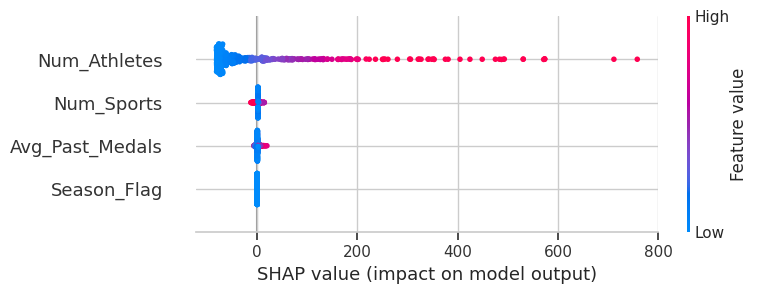

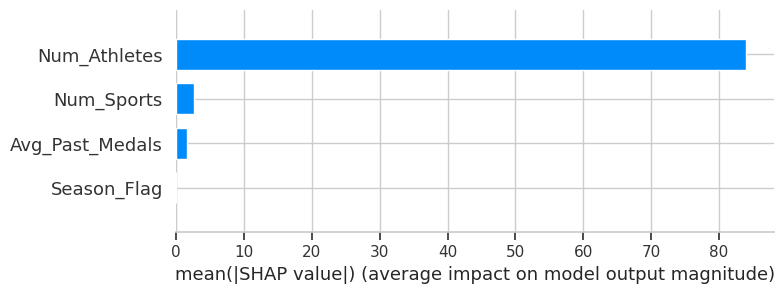

In [182]:
# Step 10: SHAP Analysis
# ---------------------------------------------------------------
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features)
shap.summary_plot(shap_values, X_test, plot_type='bar', feature_names=features)

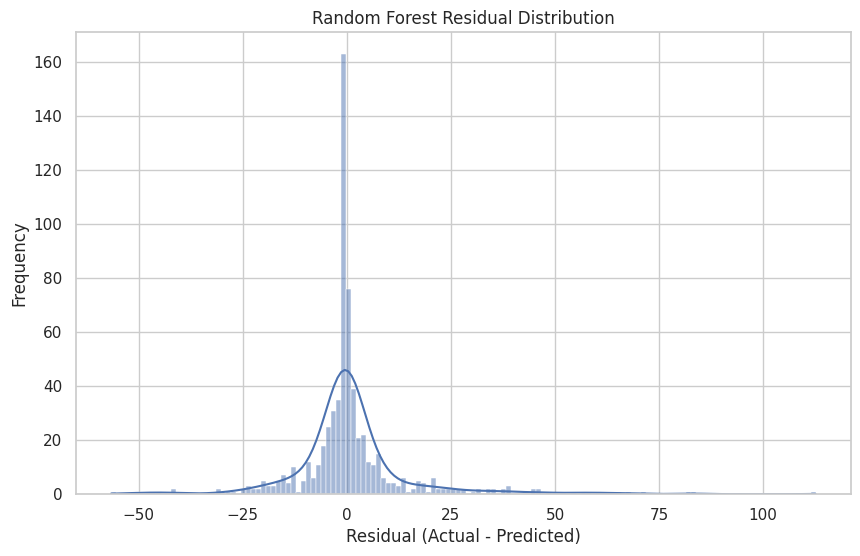

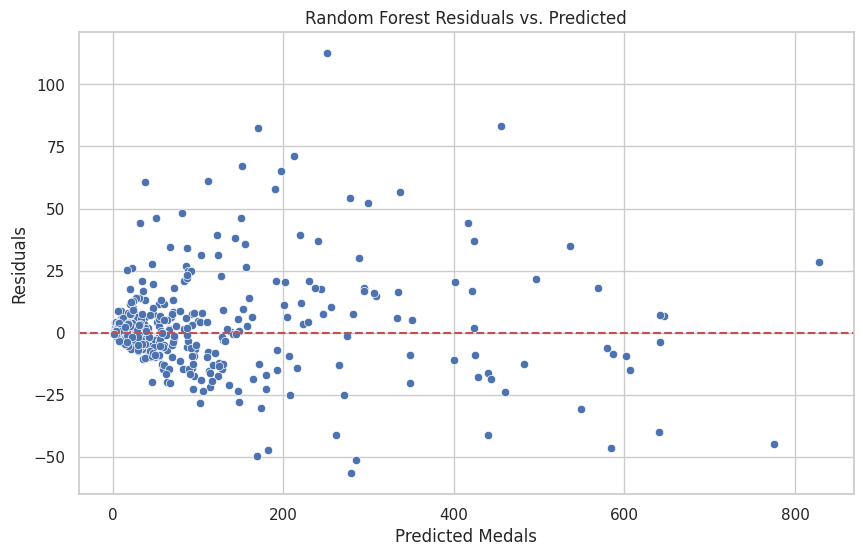

In [183]:
# Step 11: Residual Analysis on Best Model
# ---------------------------------------------------------------
y_pred = final_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title(f"{best_model_name} Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f"{best_model_name} Residuals vs. Predicted")
plt.xlabel("Predicted Medals")
plt.ylabel("Residuals")
plt.show()

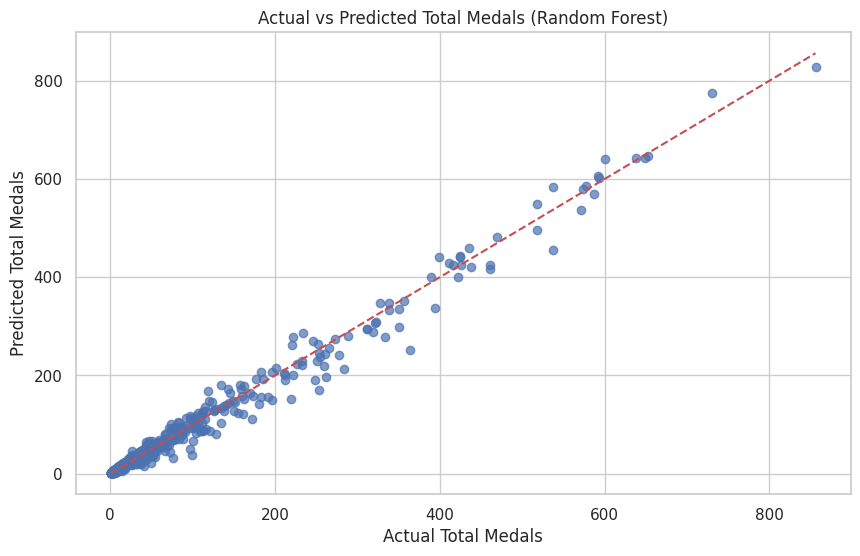


Final Model Performance:
Random Forest - MSE: 227.0597, MAE: 7.7124, R²: 0.9854


In [184]:
# Actual vs Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.title(f"Actual vs Predicted Total Medals ({best_model_name})")
plt.xlabel("Actual Total Medals")
plt.ylabel("Predicted Total Medals")
plt.grid(True)
plt.show()

# Step 12: Conclusion
# ---------------------------------------------------------------
final_mse, final_mae, final_r2 = evaluate_model(final_model, X_test, y_test)
print("\nFinal Model Performance:")
print(f"{best_model_name} - MSE: {final_mse:.4f}, MAE: {final_mae:.4f}, R²: {final_r2:.4f}")

# **Neural Network**

In [185]:
# ======================================
# STEP 1: Data Loading
np.random.seed(42)
df = pd.read_csv(dataset_url)
df.head()

,player_id,Name,Sex,Team,NOC,Year,Season,City,Sport,Event,Medal
0,0,A Dijiang,M,China,CHN,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No medal
1,1,A Lamusi,M,China,CHN,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No medal
2,2,Gunnar Aaby,M,Denmark,DEN,1920,Summer,Antwerpen,Football,Football Men's Football,No medal
3,3,Edgar Aabye,M,Denmark/Sweden,DEN,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,26,Cornelia (-strannood),F,Netherlands,NED,1932,Summer,Los Angeles,Athletics,Athletics Women's 100 metres,No medal


In [186]:
agg_df = df.groupby(['NOC','Year']).agg(
    gold_count=('Medal', lambda x: (x=='Gold').sum()),
    silver_count=('Medal', lambda x: (x=='Silver').sum()),
    bronze_count=('Medal', lambda x: (x=='Bronze').sum()),
    total_athletes=('Name','count'),
    total_events=('Event','nunique'),
    season_mode=('Season', lambda x: x.mode()[0] if not x.mode().empty else 'Summer')
).reset_index()

# Host feature:
host_map = {
    1896: "GRE",
    1900: "FRA",
    1904: "USA",
    1908: "GBR",
    1912: "SWE",
    1920: "BEL",
    1924: "FRA",
    1928: "NED",
    1932: "USA",
    1936: "GER",
    1948: "GBR",
    1952: "FIN",
    1956: "AUS",
    1960: "ITA",
    1964: "JPN",
    1968: "MEX",
    1972: "GER",
    1976: "CAN",
    1980: "URS",
    1984: "USA",
    1988: "KOR",
    1992: "ESP",
    1996: "USA",
    2000: "AUS",
    2004: "GRE",
    2008: "CHN",
    2012: "GBR",
    2016: "BRA",
    2020: "JPN",
    2024: "FRA"
}
# One hot-encode for host
agg_df['host'] = agg_df.apply(lambda row: 1 if row['NOC'] == host_map.get(row['Year'], '') else 0, axis=1)

agg_df.head()

,NOC,Year,gold_count,silver_count,bronze_count,total_athletes,total_events,season_mode,host
0,AFG,1936,0,0,0,16,4,Summer,0
1,AFG,1948,0,0,0,25,2,Summer,0
2,AFG,1956,0,0,0,12,1,Summer,0
3,AFG,1960,0,0,0,16,13,Summer,0
4,AFG,1964,0,0,0,8,8,Summer,0


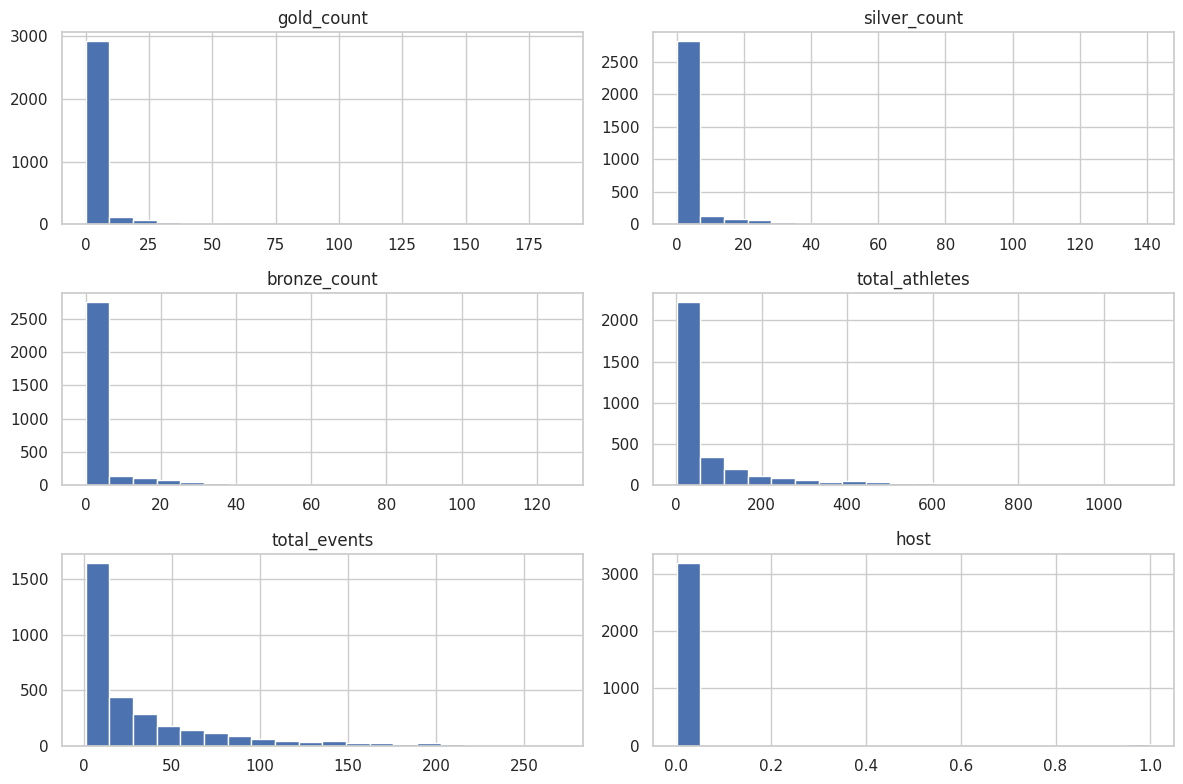

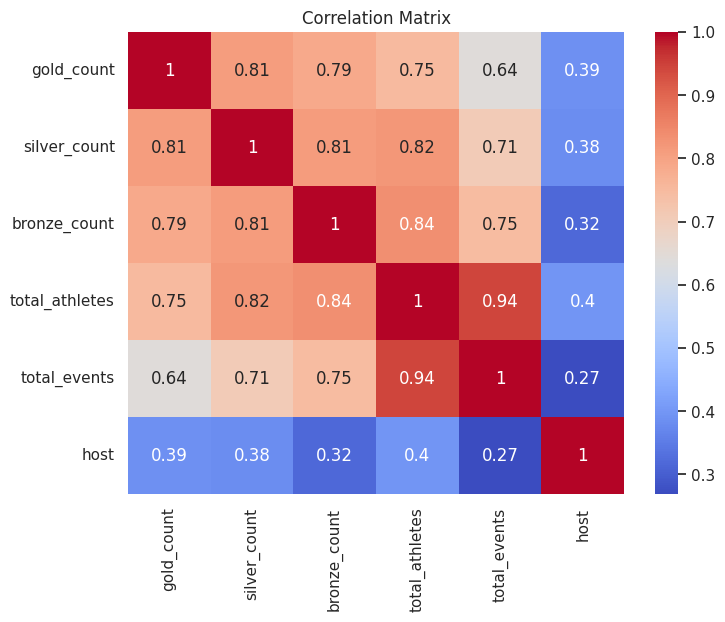

In [187]:
# ======================================
# STEP 3: Exploratory Data Analysis (EDA)
#
# Check distributions, correlations
# ======================================

numeric_features = ['gold_count','silver_count','bronze_count','total_athletes','total_events','host']
agg_df[numeric_features].hist(figsize=(12,8), bins=20)
plt.tight_layout()
plt.show()

# Correlation matrix
corr = agg_df[numeric_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [188]:
# ======================================
# STEP 4: Prepare Data for Modeling
#
# Targets: gold_count, silver_count, bronze_count (multi-output regression)
# Features: NOC (cat), Year (num), season_mode (cat), total_athletes (num), total_events (num), host (num)
# ======================================

X = agg_df[['NOC','Year','season_mode','total_athletes','total_events','host']]
y = agg_df[['gold_count','silver_count','bronze_count']]

cat_cols = ['NOC','season_mode']
num_cols = ['Year','total_athletes','total_events','host']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

X_transformed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
print("Shape of Training Set:", X_train.shape)
print("Shape of Testing Set:", X_test.shape)
print("Shape of Training Targets:", y_train.shape)
print("Shape of Testing Targets:", y_test.shape)

Shape of Training Set: (2577, 239)
Shape of Testing Set: (645, 239)
Shape of Training Targets: (2577, 3)
Shape of Testing Targets: (645, 3)


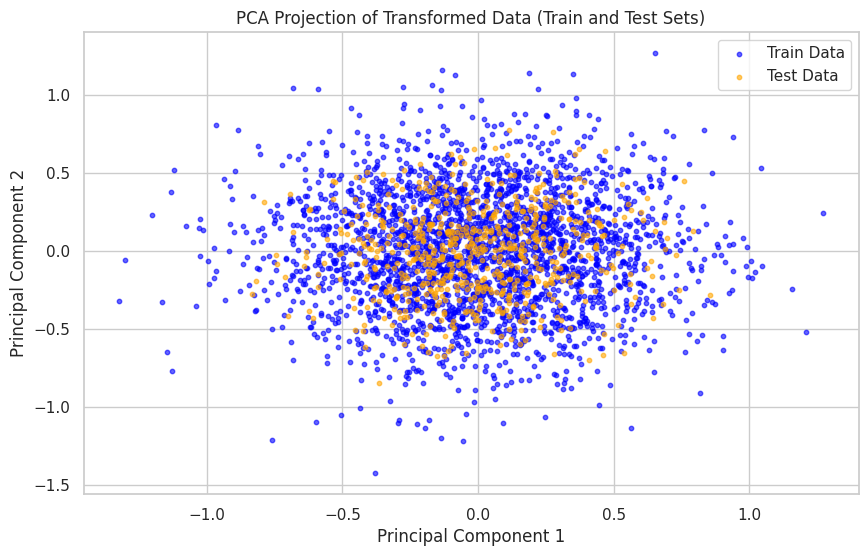

In [189]:
# Applying PCA to reduce dimensions for visualization

np.random.seed(42)
X_train_simulated = np.random.rand(2577, 239)
X_test_simulated = np.random.rand(645, 239)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_simulated)
X_test_pca = pca.transform(X_test_simulated)

# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.6, label="Train Data", c='blue', s=10)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], alpha=0.6, label="Test Data", c='orange', s=10)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Transformed Data (Train and Test Sets)")
plt.legend()
plt.show()

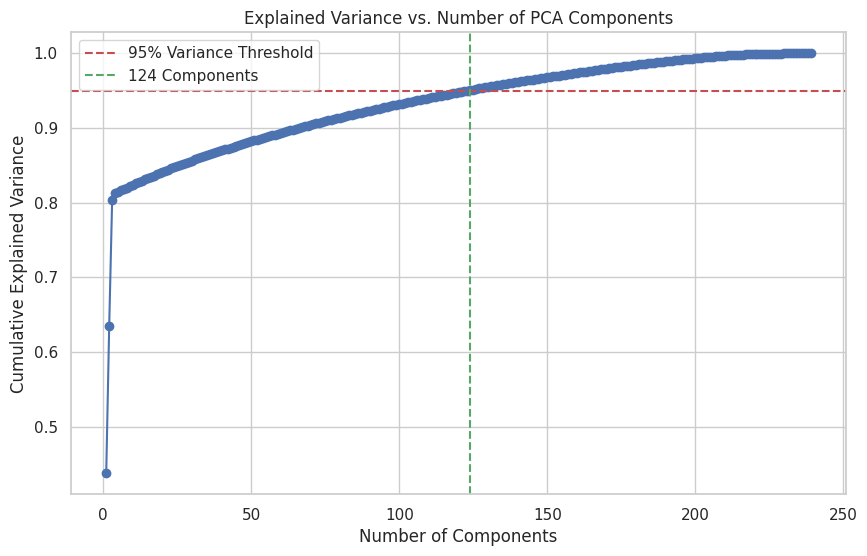

Original Training Data Shape: (2577, 239)
Reduced Training Data Shape: (2577, 124)
Original Testing Data Shape: (645, 239)
Reduced Testing Data Shape: (645, 124)


In [190]:
# Step 1: Fit PCA on the training data and compute explained variance
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train  # Handle sparse matrices
pca = PCA()
pca.fit(X_train_dense)

# Step 2: Calculate cumulative explained variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
optimal_components = np.argmax(explained_variance_ratio >= 0.95) + 1  # Find components for 95% variance

# Plot explained variance to visualize
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=optimal_components, color='g', linestyle='--', label=f'{optimal_components} Components')
plt.title('Explained Variance vs. Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.show()

# Step 3: Transform the data with the optimal number of components
pca_optimal = PCA(n_components=optimal_components)
X_train_pca = pca_optimal.fit_transform(X_train_dense)
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test
X_test_pca = pca_optimal.transform(X_test_dense)

# Output the new shapes
print(f"Original Training Data Shape: {X_train_dense.shape}")
print(f"Reduced Training Data Shape: {X_train_pca.shape}")
print(f"Original Testing Data Shape: {X_test_dense.shape}")
print(f"Reduced Testing Data Shape: {X_test_pca.shape}")

In [191]:
# Step 1: Apply PCA to reduce dimensions
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train  # Handle sparse matrices
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Fit PCA on training data to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

print(f"Original Training Data Shape: {X_train_dense.shape}")
print(f"PCA-Reduced Training Data Shape: {X_train_pca.shape}")
print(f"Original Testing Data Shape: {X_test_dense.shape}")
print(f"PCA-Reduced Testing Data Shape: {X_test_pca.shape}")

Original Training Data Shape: (2577, 239)
PCA-Reduced Training Data Shape: (2577, 124)
Original Testing Data Shape: (645, 239)
PCA-Reduced Testing Data Shape: (645, 124)


In [192]:
# ======================================
# STEP 5: Build Two Different Neural Network Models
#
# Model A: ReLU activation in hidden layers
# Model B: tanh activation in hidden layers
#
# We'll try different batch sizes and epochs to find the best model.
# Compare performance using R² and MAE.
# ======================================

# Update model creation and training to use PCA-transformed data
def create_model(input_dim, hidden_layers=[64,32], activation='relu', learning_rate=0.001):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))
    for units in hidden_layers:
        model.add(layers.Dense(units, activation=activation))
    # Output layer: 3 outputs for gold, silver, bronze
    model.add(layers.Dense(3, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse')  # MSE for regression
    return model

# Using PCA-transformed data
input_dim = X_train_pca.shape[1]

batch_sizes = [32, 64]
epochs_list = [20, 40]

# Initialize variables to track the best models
best_score = -np.inf  # for R², higher is better
best_config = None
best_model = None
best_model_type = None

# DataFrames to store performance metrics
performance_records = []

# Evaluation function
def evaluate_model(y_true, y_pred):
    r2_gold = r2_score(y_true['gold_count'], y_pred[:, 0])
    r2_silver = r2_score(y_true['silver_count'], y_pred[:, 1])
    r2_bronze = r2_score(y_true['bronze_count'], y_pred[:, 2])
    avg_r2 = (r2_gold + r2_silver + r2_bronze) / 3.0

    mae_gold = mean_absolute_error(y_true['gold_count'], y_pred[:, 0])
    mae_silver = mean_absolute_error(y_true['silver_count'], y_pred[:, 1])
    mae_bronze = mean_absolute_error(y_true['bronze_count'], y_pred[:, 2])
    avg_mae = (mae_gold + mae_silver + mae_bronze) / 3.0

    return avg_r2, avg_mae

# Best configurations for ReLU and Tanh
best_model_a = None
best_score_a = -np.inf
best_config_a = None

best_model_b = None
best_score_b = -np.inf
best_config_b = None

# Loop through configurations
for batch_size in batch_sizes:
    for epochs in epochs_list:
        # Model A (ReLU)
        model_a = create_model(input_dim, activation='relu')
        history_a = model_a.fit(X_train_pca, y_train, validation_split=0.2,
                                epochs=epochs, batch_size=batch_size, verbose=0)
        y_pred_a = model_a.predict(X_test_pca)
        score_a, mae_a = evaluate_model(y_test, y_pred_a)

        performance_records.append({
            'Model': 'A (ReLU)',
            'Batch Size': batch_size,
            'Epochs': epochs,
            'Avg R²': score_a,
            'Avg MAE': mae_a
        })

        if score_a > best_score_a:
            best_score_a = score_a
            best_config_a = (batch_size, epochs)
            best_model_a = model_a
            history_best_a = history_a

        # Model B (tanh)
        model_b = create_model(input_dim, activation='tanh')
        history_b = model_b.fit(X_train_pca, y_train, validation_split=0.2,
                                epochs=epochs, batch_size=batch_size, verbose=0)
        y_pred_b = model_b.predict(X_test_pca)
        score_b, mae_b = evaluate_model(y_test, y_pred_b)

        performance_records.append({
            'Model': 'B (tanh)',
            'Batch Size': batch_size,
            'Epochs': epochs,
            'Avg R²': score_b,
            'Avg MAE': mae_b
        })

        if score_b > best_score_b:
            best_score_b = score_b
            best_config_b = (batch_size, epochs)
            best_model_b = model_b
            history_best_b = history_b

# Convert performance records to DataFrame
performance_df = pd.DataFrame(performance_records)

print("Best Model A (ReLU) configuration:", best_config_a, "with avg R² score:", best_score_a)
print("Best Model B (tanh) configuration:", best_config_b, "with avg R² score:", best_score_b)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Best Model A (ReLU) configuration: (32, 20) with avg R² score: 0.7721245884895325
Best Model B (tanh) configuration: (32, 40) with avg R² score: 0.7088788350423177


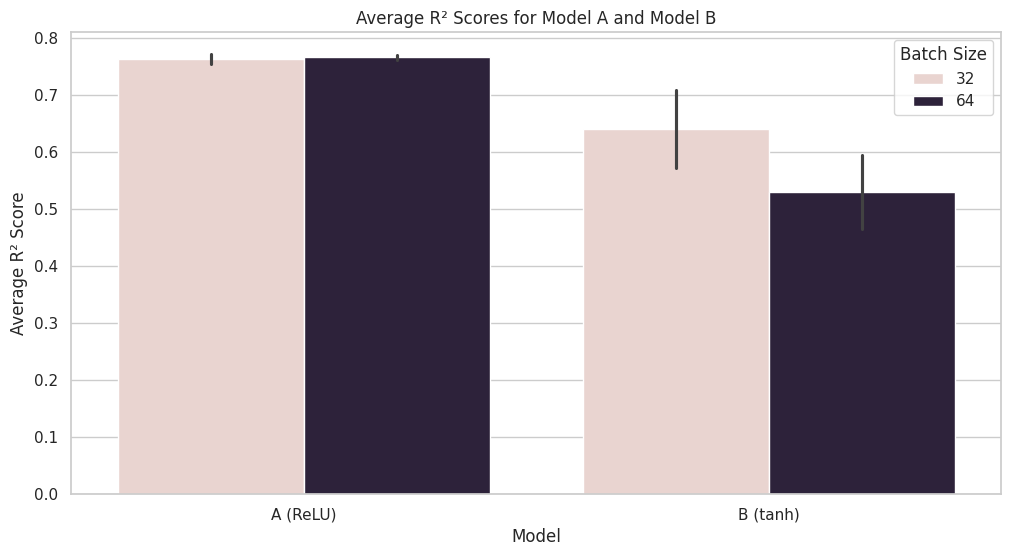

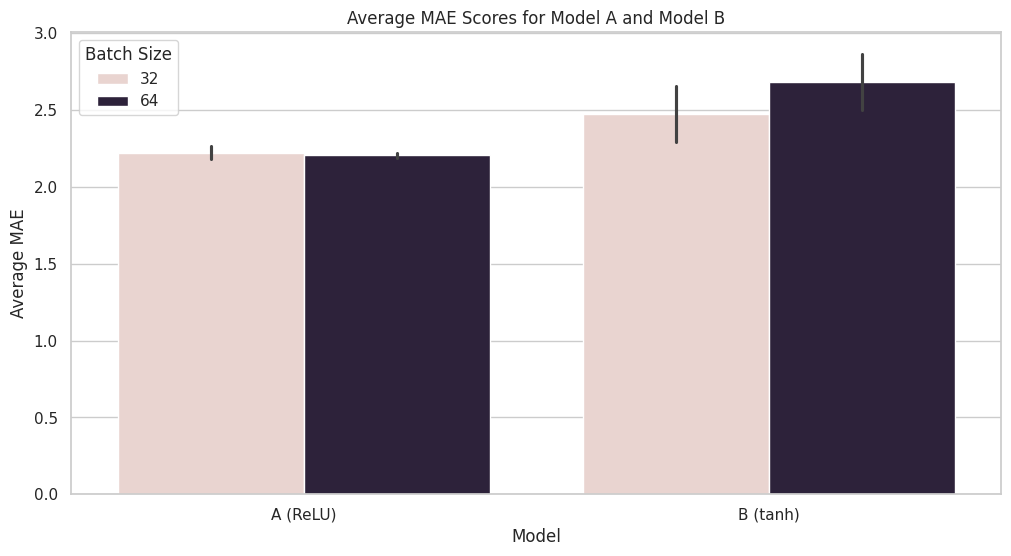

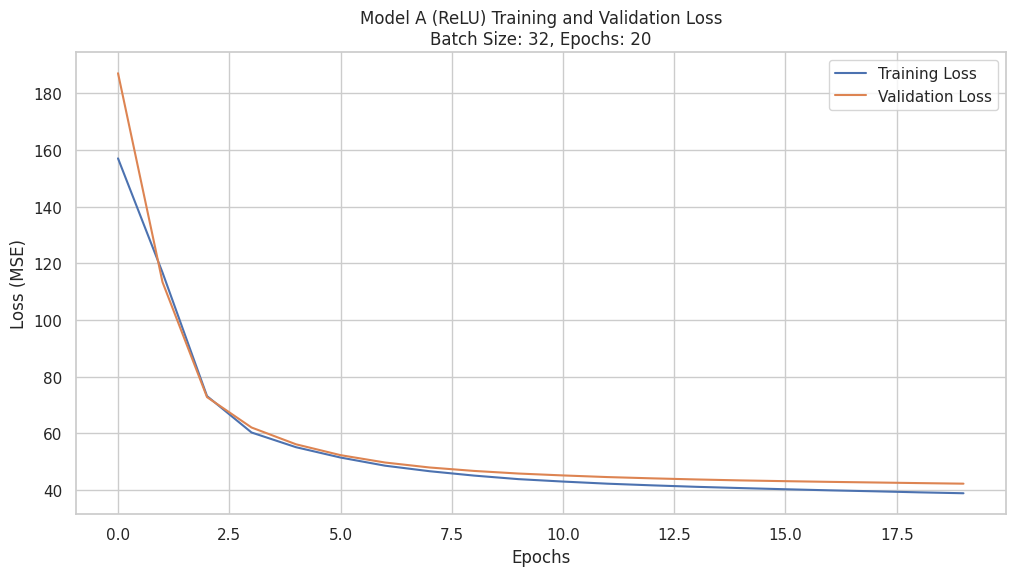

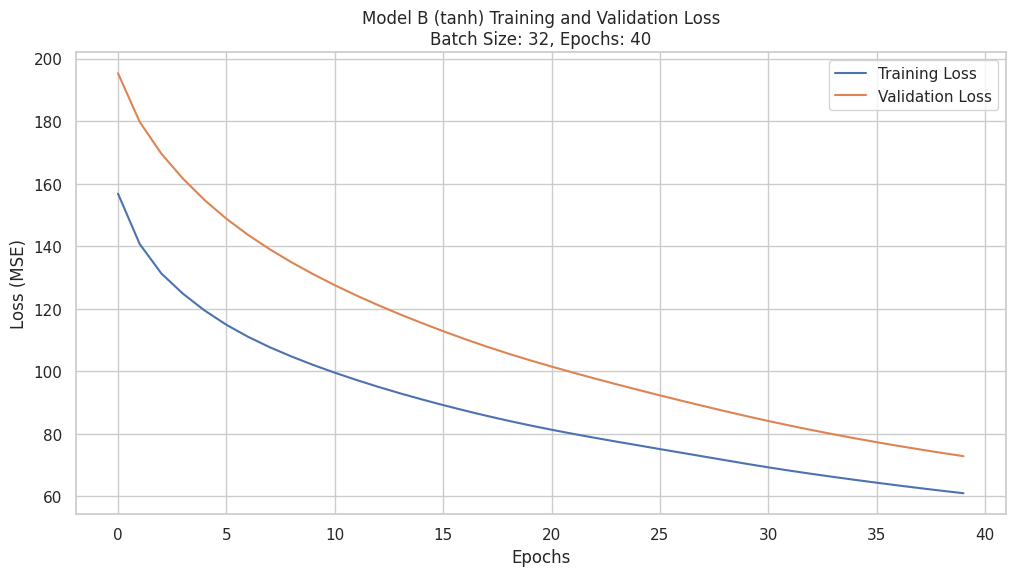

In [193]:
# ======================================
# Plotting Performance Metrics
# ======================================

# Set plot style
sns.set(style="whitegrid")

# 1. Plot Average R² Scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Avg R²', hue='Batch Size', data=performance_df)
plt.title('Average R² Scores for Model A and Model B')
plt.ylabel('Average R² Score')
plt.xlabel('Model')
plt.legend(title='Batch Size')
plt.show()

# 2. Plot Average MAE Scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Avg MAE', hue='Batch Size', data=performance_df)
plt.title('Average MAE Scores for Model A and Model B')
plt.ylabel('Average MAE')
plt.xlabel('Model')
plt.legend(title='Batch Size')
plt.show()

# 3. Plot Training and Validation Loss for Best Model A
plt.figure(figsize=(12, 6))
plt.plot(history_best_a.history['loss'], label='Training Loss')
plt.plot(history_best_a.history['val_loss'], label='Validation Loss')
plt.title(f'Model A (ReLU) Training and Validation Loss\nBatch Size: {best_config_a[0]}, Epochs: {best_config_a[1]}')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# 4. Plot Training and Validation Loss for Best Model B
plt.figure(figsize=(12, 6))
plt.plot(history_best_b.history['loss'], label='Training Loss')
plt.plot(history_best_b.history['val_loss'], label='Validation Loss')
plt.title(f'Model B (tanh) Training and Validation Loss\nBatch Size: {best_config_b[0]}, Epochs: {best_config_b[1]}')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


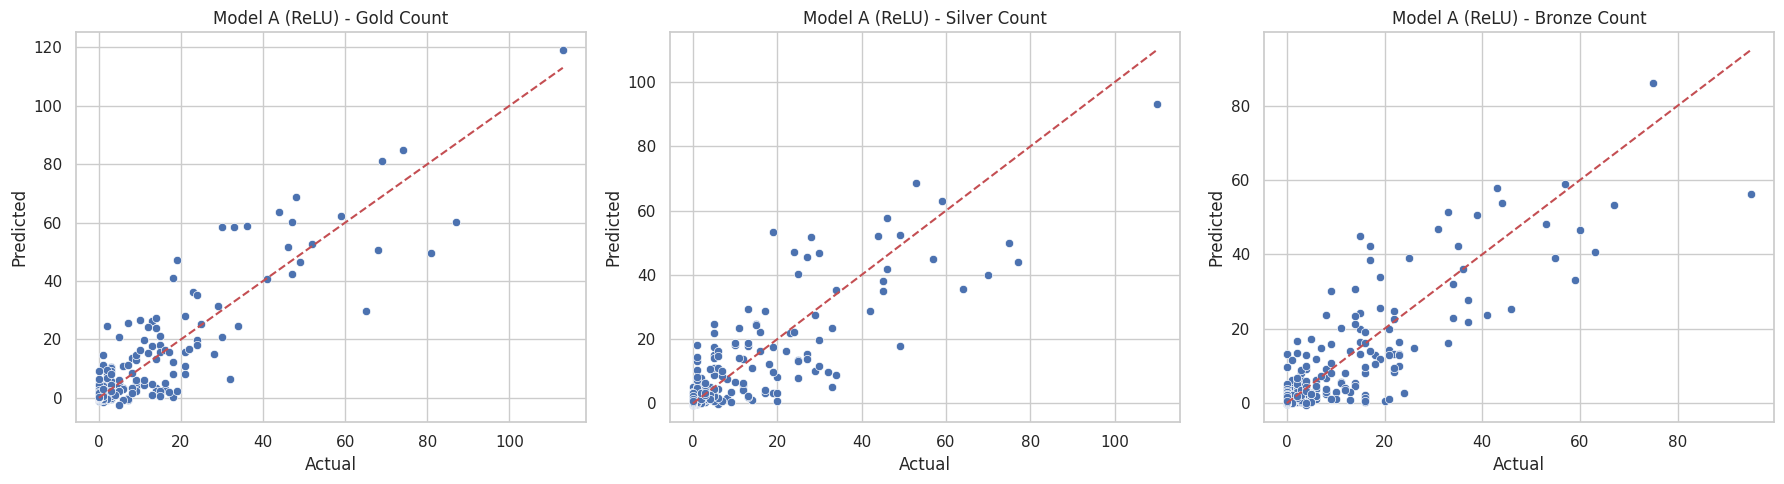

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


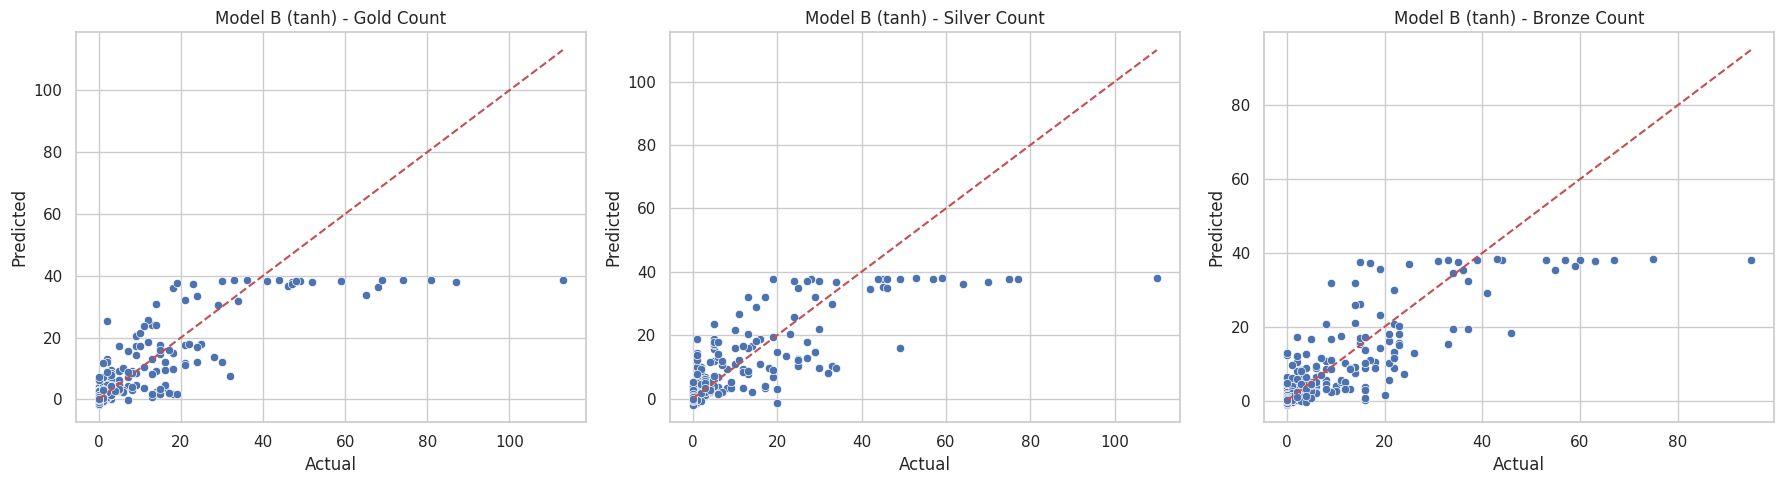

In [194]:
# 5. Plot Predicted vs Actual for Best Model A
y_pred_best_a = best_model_a.predict(X_test_pca)  # Use PCA-transformed test data

plt.figure(figsize=(18, 5))

for i, medal in enumerate(['Gold', 'Silver', 'Bronze']):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=y_test[f'{medal.lower()}_count'], y=y_pred_best_a[:, i])
    plt.plot([y_test[f'{medal.lower()}_count'].min(), y_test[f'{medal.lower()}_count'].max()],
             [y_test[f'{medal.lower()}_count'].min(), y_test[f'{medal.lower()}_count'].max()],
             'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Model A (ReLU) - {medal} Count')

plt.tight_layout()
plt.show()

# 6. Plot Predicted vs Actual for Best Model B
y_pred_best_b = best_model_b.predict(X_test_pca)  # Use PCA-transformed test data

plt.figure(figsize=(18, 5))

for i, medal in enumerate(['Gold', 'Silver', 'Bronze']):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=y_test[f'{medal.lower()}_count'], y=y_pred_best_b[:, i])
    plt.plot([y_test[f'{medal.lower()}_count'].min(), y_test[f'{medal.lower()}_count'].max()],
             [y_test[f'{medal.lower()}_count'].min(), y_test[f'{medal.lower()}_count'].max()],
             'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Model B (tanh) - {medal} Count')

plt.tight_layout()
plt.show()